In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

DC = 10 # diffusion coeff [microns^2 s^-1]

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
N = len(seg_list)
n = N

In [4]:
for i in range(len(sec_list)):
    sec = sec_list[i]
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]
2: dend_5[0], nseg=1, L=27.29313676464808, or=0.0, hname=dend_5[0]
3: apic[0], nseg=9, L=147.93433051396065, or=0.0, hname=apic[0]
4: dend_5[1], nseg=3, L=57.45149110486393, or=0.0, hname=dend_5[1]
5: apic[39], nseg=1, L=23.29171407802628, or=0.0, hname=apic[39]
6: apic[41], nseg=3, L=34.922839435595144, or=0.0, hname=apic[41]
7: apic[40], nseg=5, L=52.39168693889804, or=0.0, hname=apic[40]
8: dend_5[2], nseg=1, L=21.183727600433784, or=0.0, hname=dend_5[2]
9: apic[32], nseg=1, L=12.617619533060896, or=0.0, hname=apic[32]
10: apic[38], nseg=13, L=208.40219120020532, or=0.0, hname=apic[38]
11: apic[33], nseg=1, L=9.679981164937955, or=0.0, hname=apic[33]
12: apic[37], nseg=3, L=32.69642802210867, or=0.0, hname=apic[37]
13: apic[34], nseg=1, L=6.683028121429655, or=0.0, hname=apic[34]
14: apic[36], nseg=5, L=58.600785345533666, or=0.0, hname=apic[36]
15: apic[35

In [5]:
import re
import pandas as pd
p = re.compile("^([^\\[]+)\\[.+")
tps = [p.sub("\\1",seg.sec.name()) for seg in seg_list]
pd.Series(tps).drop_duplicates().tolist()

['soma', 'dend_5', 'apic', 'dend', 'axon']

In [6]:
def sushi_system(a,b,c,d,l):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for u* turning into u is given by the vector "d"
    The rate constants for the degradation of u* is given by the vector "l"
    """
    # number of compartments
    N = len(l)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]
    
    # Reattachment to belt
    #for i in range(N):
    #    # reattachment
    #    A[i, i + N] += d[i]
    #    A[i + N, i + N] += -d[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -l[i]
    
    return A

In [7]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3,dscale=0.1,dv=1e-7):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    l = list(np.ones(n)*dv)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    d = list([ci * dscale for ci in c])
    A = sushi_system(a,b,c,d,l)
    return A

In [8]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*N)
u0[0] = 1.0  # compartment 0 is the soma

In [9]:
def solve_u(u0,w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def sim_time(A,u0,time,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,math.log10(time),nframes)
    for t_ in t: utrace.append(solve_u(u0,w,V,Vinv,t_))
    return np.array(utrace).T


def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035],cmap=plt.cm.cool):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=cmap,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

Read Experimental Data
----

In [10]:
tdf=pd.read_csv('data/seg_mapping.csv')
abbCA1=tdf['abb']
abbT={}
segIdx={}
for i in range(N):
    abbT[abbCA1[i]] = 1+ abbT.get(abbCA1[i],0)
    ll=segIdx.get(abbCA1[i],[])
    ll.append(i)
    segIdx[abbCA1[i]] = ll

(abbCA1,abbT,segIdx.keys(),{k:len(segIdx.get(k)) for k in segIdx.keys()})

(0       Soma_0
 1       Soma_0
 2      CA1sr_1
 3      CA1sr_1
 4      CA1sr_2
         ...   
 737        NaN
 738        NaN
 739        NaN
 740        NaN
 741        NaN
 Name: abb, Length: 742, dtype: object,
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1slm_1': 13,
  'CA1slm_2': 24,
  'CA1slm_3': 35,
  'CA1slm_4': 29,
  'CA1slm_5': 9,
  'CA1so_5': 16,
  'CA1so_4': 100,
  'CA1so_3': 134,
  'CA1so_2': 85,
  'CA1so_1': 9,
  nan: 5},
 dict_keys(['Soma_0', 'CA1sr_1', 'CA1sr_2', 'CA1sr_3', 'CA1sr_4', 'CA1sr_5', 'CA1sr_6', 'CA1sr_7', 'CA1sr_8', 'CA1sr_9', 'CA1sr_10', 'CA1slm_1', 'CA1slm_2', 'CA1slm_3', 'CA1slm_4', 'CA1slm_5', 'CA1so_5', 'CA1so_4', 'CA1so_3', 'CA1so_2', 'CA1so_1', nan]),
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9'

In [11]:
ks=[i for i in segIdx.keys()]
(ks[0],segIdx[ks[0]])

('Soma_0', [0, 1])

In [12]:
sec=seg_list[0]
sec.sec.name()

'soma[0]'

In [13]:
sname=[]
hname=[]
for i in range(len(seg_list)):
    sec = seg_list[i].sec
    sname.append(sec.name())
    hname.append(sec.hname())
#(sname,hname)

In [14]:
for i in segIdx[ks[0]]:
    sec = seg_list[i].sec
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]


In [15]:
expD=pd.read_csv('data/CA1_gradient.csv')
subreg = ['CA1so', 'CA1sr', 'CA1slm']
expD

,Abbreviation,Subregion,D0W3_MEAN,D0W3_SD,D7W3_MEAN,D7W3_SD,D0M3_MEAN,D0M3_SD,D7M3_MEAN,D7M3_SD,D0M318_MEAN,D0M318_SD,D7M318_MEAN,D7M318_SD
0,CA1so_1,CA1so,57.666667,14.497175,2.306667,3.262119,58.820000,7.474454,25.373333,4.315378,68.046667,6.524239,29.986667,1.631060
1,CA1so_2,CA1so,89.960000,12.946135,5.766667,8.155298,87.653333,8.155298,44.980000,2.825078,94.573333,1.631060,51.900000,5.650156
2,CA1so_3,CA1so,100.340000,14.948909,6.920000,9.786358,96.880000,9.786358,51.900000,4.893179,101.493333,3.262119,57.666667,7.109624
3,CA1so_4,CA1so,99.186667,14.497175,5.766667,8.155298,96.880000,9.786358,46.133333,7.109624,103.800000,2.825078,53.053333,8.630756
4,CA1so_5,CA1so,83.040000,17.642608,2.306667,3.262119,87.653333,10.695573,28.833333,7.109624,98.033333,3.262119,32.293333,9.921348
5,CA1sr_1,CA1sr,70.353333,10.695573,3.460000,4.893179,69.200000,7.474454,29.986667,3.262119,74.966667,3.262119,36.906667,4.315378
6,CA1sr_2,CA1sr,89.383333,12.341206,5.766667,8.155298,80.733333,8.155298,36.906667,5.880869,85.346667,1.631060,42.673333,5.880869
7,CA1sr_3,CA1sr,94.573333,13.350799,6.920000,9.786358,84.193333,10.695573,40.943333,5.708709,88.806667,1.631060,48.440000,4.893179
8,CA1sr_4,CA1sr,95.726667,11.761738,8.073333,11.417417,85.346667,9.081356,44.980000,4.893179,88.806667,4.315378,53.053333,5.880869
9,CA1sr_5,CA1sr,94.573333,10.695573,9.226667,13.048477,84.193333,8.155298,47.286667,5.880869,87.653333,4.315378,55.360000,5.650156


In [16]:
import sushibelt
import time

Day 0 3 month
------

In [17]:
bgSignal = 1e-5
cname0='D0M3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

#cname='D7W3'
cname7='D7M3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

def calcUtrace(par,delta=bgSignal,nframes=10):
    F = par[0]
    Ctau = 10 ** par[1]
    mProp = par[2]
    dvA = par[3]
    dvB = par[4]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = par[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7,nframes=nframes)
    return utrace

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
#par = [0.0,-2.847372550934951,0.20430623530833164,-5.754630055624563,-5.8321723784857635,-6.0649088262203215,0.9999999999999993,0.9550522528085269,0.001]
#cost = 0.00010140231658948862
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
bpar = par

In [18]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'F': 0.8861278052764772,
 'Ctau': 4.384055873241875e-06,
 'mProp': 0.3127455791698551,
 'dvA': 1.8378828974092036e-06,
 'dvB': 1.0022296567714719e-18,
 'demand_CA1so_1': 0.21382364663804718,
 'demand_CA1so_2': 0.06074280874523973,
 'demand_CA1so_3': 0.04781382417616123,
 'demand_CA1so_4': 0.04562340830020193,
 'demand_CA1so_5': 1.0000000000039887e-07,
 'demand_CA1sr_1': 0.7733439929081787,
 'demand_CA1sr_2': 0.5543045057407645,
 'demand_CA1sr_3': 0.1468913931288651,
 'demand_CA1sr_4': 0.14710118884157364,
 'demand_CA1sr_5': 0.1316203146580693,
 'demand_CA1sr_6': 0.15499357159791044,
 'demand_CA1sr_7': 0.17296720163305693,
 'demand_CA1sr_8': 0.20287137824434023,
 'demand_CA1sr_9': 0.3735878952746845,
 'demand_CA1sr_10': 0.5243019440900127,
 'demand_CA1slm_1': 0.043864102155039865,
 'demand_CA1slm_2': 0.1966480252602025,
 'demand_CA1slm_3': 0.19591970216660096,
 'demand_CA1slm_4': 0.2755074889018492,
 'demand_CA1slm_5': 0.9999999999999992,
 'sum_resM': 0.022058251276583223,
 'sum_resF':

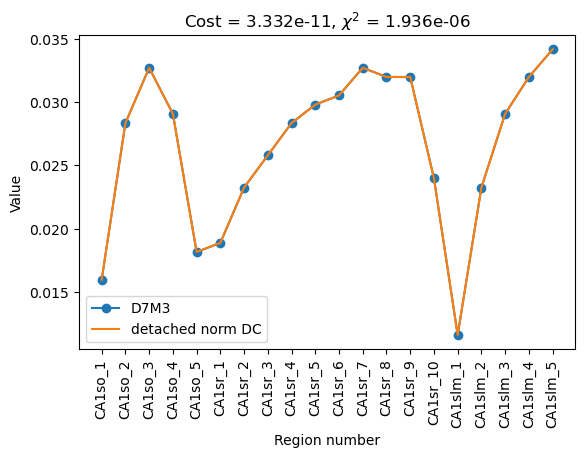

In [19]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
plt.show()


# F

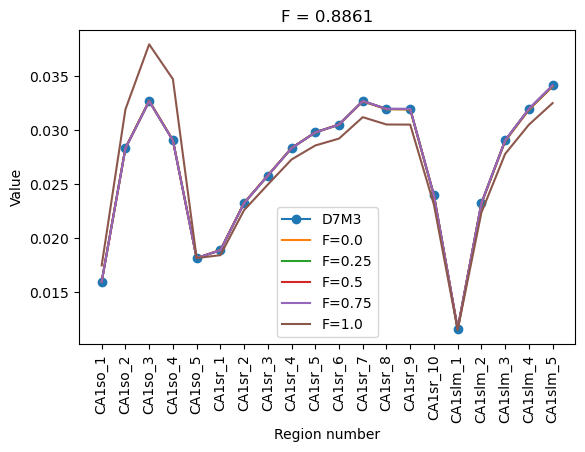

In [20]:
fpar=par.copy()
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
#ax.plot(x,resF/(1-mProp),label='detached norm DC')
for fv in range(5):
    fpar[0] = fv/4;
    futrace = calcUtrace(fpar)
    fresM, fresF = sushibelt.aggregate_segments(futrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,fresF/(1-mProp),label=f"F={fv/4}")
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"F = {format(par[0],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_plot.png')
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_plot.pdf')
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_plot.svg')


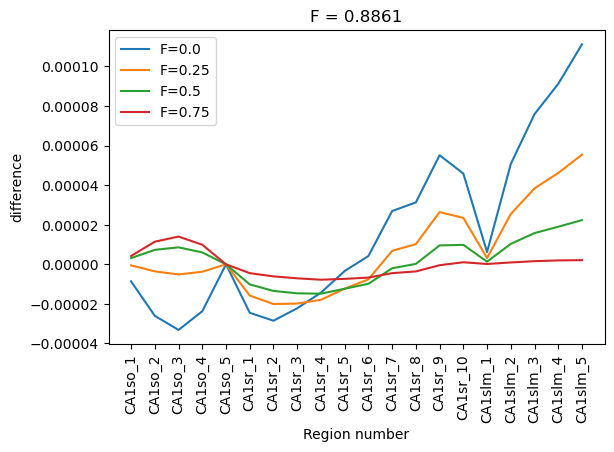

In [21]:
fpar=par.copy()
fig, ax = plt.subplots()
for fv in range(4):
    fpar[0] = fv/4;
    futrace = calcUtrace(fpar)
    fresM, fresF = sushibelt.aggregate_segments(futrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,(resF-fresF)/(1-mProp),label=f"F={fv/4}")
ax.set_xlabel('Region number')
ax.set_ylabel('difference')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"F = {format(par[0],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_diff.png')
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_diff.pdf')
plt.savefig('whatIfEdita_20reg_1dv_F_20241209_diff.svg')


# Ctau

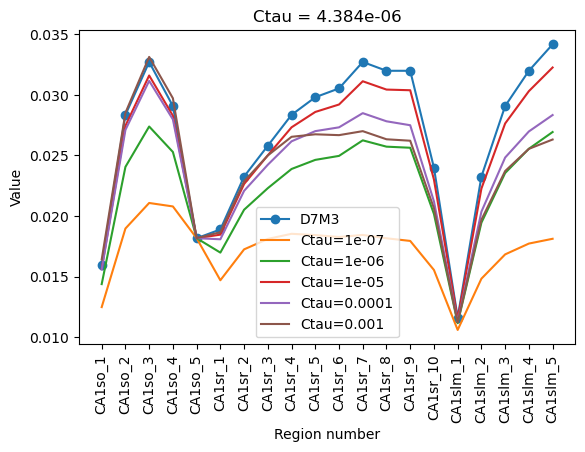

In [22]:
cpar=par.copy()
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
#ax.plot(x,resF/(1-mProp),label='detached norm DC')
for cv in range(5):
    cpar[1] = cv-7;
    cutrace = calcUtrace(cpar)
    cresM, cresF = sushibelt.aggregate_segments(cutrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,cresF/(1-mProp),label=f"Ctau={format(10 ** cpar[1],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Ctau = {format(10 ** par[1],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_plot.png')
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_plot.pdf')
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_plot.svg')


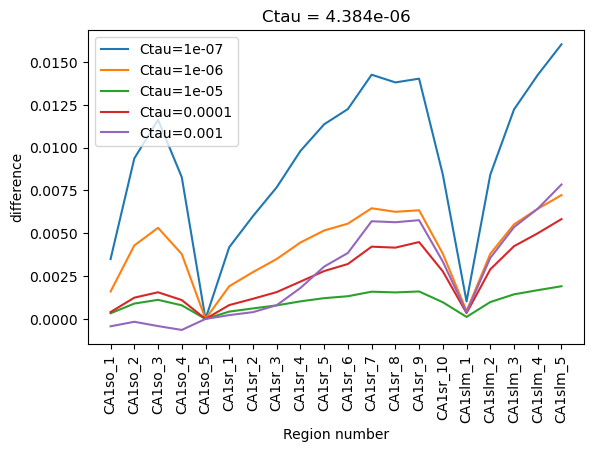

In [23]:
cpar=par.copy()
fig, ax = plt.subplots()
for cv in range(5):
    cpar[1] = cv-7;
    cutrace = calcUtrace(cpar)
    cresM, cresF = sushibelt.aggregate_segments(cutrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,(resF-cresF)/(1-mProp),label=f"Ctau={format(10 ** cpar[1],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('difference')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Ctau = {format(10 ** par[1],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_diff.png')
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_diff.pdf')
plt.savefig('whatIfEdita_20reg_1dv_Ctau_20241209_diff.svg')


# dvA

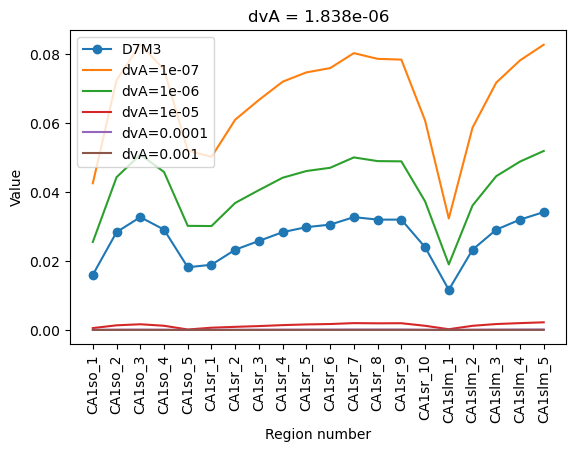

In [24]:
apar=par.copy()
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
#ax.plot(x,resF/(1-mProp),label='detached norm DC')
for av in range(5):
    apar[3] = av-7;
    autrace = calcUtrace(apar)
    aresM, aresF = sushibelt.aggregate_segments(autrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,aresF/(1-mProp),label=f"dvA={format(10 ** apar[3],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"dvA = {format(10 ** par[3],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_plot.png')
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_plot.pdf')
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_plot.svg')


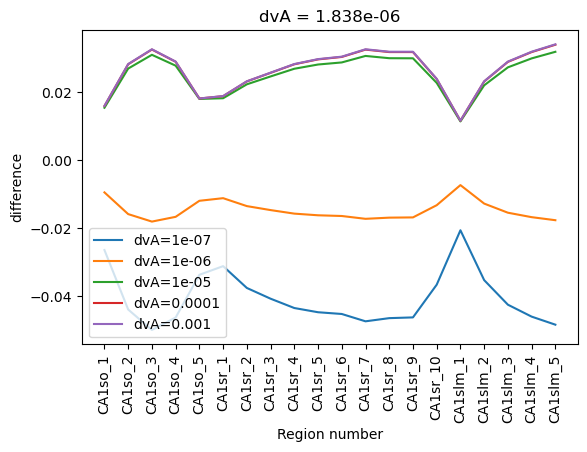

In [25]:
apar=par.copy()
fig, ax = plt.subplots()
for av in range(5):
    apar[3] = av-7;
    autrace = calcUtrace(apar)
    aresM, aresF = sushibelt.aggregate_segments(autrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,(resF-aresF)/(1-mProp),label=f"dvA={format(10 ** apar[3],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('difference')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"dvA = {format(10 ** par[3],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_diff.png')
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_diff.pdf')
plt.savefig('whatIfEdita_20reg_1dv_dvA_20241209_diff.svg')


# dvB

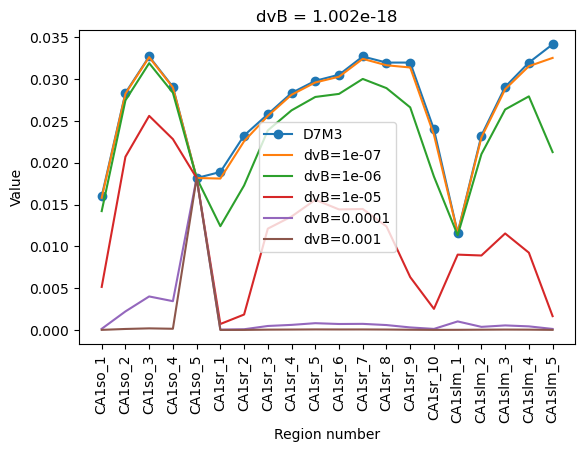

In [26]:
bpar=par.copy()
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
#ax.plot(x,resF/(1-mProp),label='detached norm DC')
for bv in range(5):
    bpar[4] = bv-7 #3*bv-18;
    butrace = calcUtrace(bpar)
    bresM, bresF = sushibelt.aggregate_segments(butrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,bresF/(1-mProp),label=f"dvB={format(10 ** bpar[4],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"dvB = {format(10 ** par[4],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_plot.png')
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_plot.pdf')
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_plot.svg')


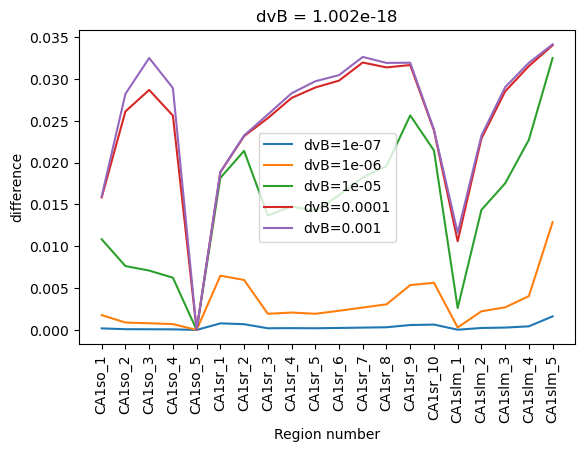

In [27]:
bpar=par.copy()
fig, ax = plt.subplots()
for bv in range(5):
    bpar[4] = bv-7;
    butrace = calcUtrace(bpar)
    bresM, bresF = sushibelt.aggregate_segments(butrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
    ax.plot(x,(resF-bresF)/(1-mProp),label=f"dvB={format(10 ** bpar[4],'.4g')}")
ax.set_xlabel('Region number')
ax.set_ylabel('difference')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"dvB = {format(10 ** par[4],'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_diff.png')
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_diff.pdf')
plt.savefig('whatIfEdita_20reg_1dv_dvB_20241209_diff.svg')
